# Audio Classification



Multi-class audio classification involves categorizing audio samples into multiple predefined classes or categories. This can be accomplished using various machine learning and signal processing techniques. Here's a simplified step-by-step process:

1. Data Collection and Preprocessing
Data Collection: Gather a diverse dataset containing audio samples for each class you want to classify.
Preprocessing: Convert audio files into a standardized format (e.g., WAV, MP3) and extract features that represent the audio content effectively. Common features include Mel-Frequency Cepstral Coefficients (MFCCs), spectrograms, or other time-frequency representations.
2. Feature Extraction
Extract Features: Utilize signal processing methods (like Fast Fourier Transform, Short-Time Fourier Transform, or other spectral analysis techniques) to extract numerical representations (features) from the audio files. These features should capture relevant information about the sound, such as its frequency content, amplitude, and temporal characteristics.
3. Model Selection and Training
Model Selection: Choose an appropriate machine learning model or technique for classification. Common models include Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), or hybrid architectures.
Training: Train the chosen model using the extracted features and corresponding class labels. This involves feeding the model with labeled data to learn the patterns and relationships between features and classes.
4. Model Evaluation
Validation: Evaluate the trained model's performance on a separate dataset (validation set) to assess its accuracy, precision, recall, and other relevant metrics. This helps in understanding how well the model generalizes to new, unseen data.
Fine-tuning: Adjust model hyperparameters or architecture based on validation results to improve performance.
5. Prediction and Deployment
Prediction: Use the trained model to classify new audio samples into their respective classes. This involves feeding new audio data through the model and obtaining predictions for their classes.
Deployment: Deploy the model in your desired application or system for real-world usage.

6. Tools and Libraries
Librosa: Python library for audio analysis and feature extraction.
TensorFlow or PyTorch: Deep learning frameworks commonly used for building neural network models for audio classification.
Scikit-learn: Useful for traditional machine learning models and preprocessing techniques.
7. Challenges
    - Data Quality: Noisy or inconsistent audio data can affect model performance.
    - Class Imbalance: Unequal representation of classes might lead to biased models.
- Tips
    - Data Augmentation: Generate more training data by applying transformations to existing audio samples (e.g., adding noise, pitch shifting).
    - Transfer Learning: Utilize pre-trained models or features learned from similar audio datasets to boost performance.
    - Ensemble Methods: Combine predictions from multiple models for improved accuracy.
Would you like further details on any specific step or technique involved in multi-class audio classification?

# Qafar-af Speech Command Recognition (QSCR)
In this notebook the speech command recognition model is build and trained using the collected Qafar-af audio dataset. The Qafar-af Audio Dataset is contain seven folders that have five keyword, and noise an unknown class organized in seven class the  using Qafar-af audio dataset a

## Import Necessary Libraries and Modules

 importing necessary libraries and module For a machine learning task involving audio classification using TensorFlow and related packages such as Librosa for audio processing, NumPy for numerical operations, and Matplotlib for visualization.

In [1]:
#using .mu.env310 Enviroment
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.layers import Reshape
import matplotlib.pyplot as plt
from IPython.display import Audio

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import lite

import random
from IPython.display import Audio, display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Load and Preprocess Audio Data:

### Setting up directory paths for:

training, testing, and validation data. These paths point to folders containing subfolders, each representing the seven classes or categories in the audio dataset

In [2]:
# Directory containing folders for each class
train_directory= "../_V_Data/splitted_QF/Train_MM"#/splitted_QF/Train_MM"
#train_directory= "../_V_Data/data_v3/train_v3"#/splitted_QF/Train_MM"

class_train = os.listdir(train_directory)

# Directory containing folders for each class
test_directory= "../_V_Data/splitted_QF/Test_MM"#/splitted_QF/Train_MM"
#test_directory= "../_V_Data/data_v3/test_v3"#/splitted_QF/Train_MM"
class_test = os.listdir(test_directory)

# Directory containing folders for each class
val_directory= "../_V_Data/splitted_QF/Val_MM"#/splitted_QF/Train_MM"
class_val = os.listdir(val_directory)

print(f'Total Class are: {class_train}')

Total Class are: ['A_noise', 'Derreh', 'Gurra', 'Migda', 'Qembis', 'Solis', 'Unknown']


### The `load_audio_data` Function

It is used to load audio data from a directory using Librosa. The function takes in the directory path where audio data is stored, a list of class folders, and an optional parameter target_sr which defaults to 16000 means the audio have sampling rate 16000 with a 1 second long. Here's a breakdown of what the function does:
1. It initializes an empty dictionary audio_ds to store audio signals for each class specified in class_folders.
2. It iterates through each class folder and loads audio files from each folder using Librosa.
3. For each audio file:
    - It loads the audio signal and resamples it to a target sampling rate (target_sr) of 16000.
    - It adjusts the length of the audio signal to match target_sr by padding or truncated the audio:
    - It appends the processed audio signal to the corresponding class key in the audio_ds dictionary.
4. Finally, the function returns the audio_ds dictionary containing lists of audio signals for each class.

In [3]:
def load_audio_data(data_directory, class_folders, target_sr=16000):
    """
    Load audio data from specified directories.

    Args:
    - data_directory (str): Path to the main data directory containing class folders.
    - class_folders (list): List of class folder names.
    - target_sr (int, optional): Target length for audio signals (default: 16000).

    Returns:
    - audio_ds (dict): Dictionary containing audio signals for each class.
    """
    audio_ds = {cls: [] for cls in class_folders}

    try:
        for cls in class_folders:
            class_directory = os.path.join(data_directory, cls)
            if not os.path.isdir(class_directory):
                raise ValueError(f"Directory '{class_directory}' not found for class '{cls}'")

            audio_files = os.listdir(class_directory)

            for file_name in audio_files:
                file_path = os.path.join(class_directory, file_name)
                if not os.path.isfile(file_path):
                    print(f"File '{file_path}' not found. Skipping...")
                    continue

                signal, sr = librosa.load(file_path, sr=target_sr, mono=True)

                if len(signal) < target_sr:
                    signal = np.pad(signal, (0, target_sr - len(signal)), 'constant')
                elif len(signal) > target_sr:
                    signal = signal[:target_sr]

                audio_ds[cls].append(signal)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

    return audio_ds

Loading audio data by using `load_audio_data` function for
- Training,
- Testing, and
- Validation datasets using separate directories and classes.

In [4]:
#Train Data
train_ds =load_audio_data(train_directory, class_train)
train_data_points = sum(len(ds_train) for ds_train in train_ds.values())
print("Total number of train Audio data:", train_data_points)

#Test Data
test_ds=load_audio_data(test_directory, class_test)
test_data_points = sum(len(ds_test) for ds_test in test_ds.values())
print("Total number of test Audio data:", test_data_points)

#Validation
val_ds=load_audio_data(val_directory, class_val)
val_data_points = sum(len(ds_val) for ds_val in val_ds.values())
print("Total number of validation Audio:", val_data_points)

Total number of train Audio data: 3152
Total number of test Audio data: 905
Total number of validation Audio: 480


### Play Audio from Dataset from all Classes

By randomly select one waveform from each label's list of waveforms and play it using IPython.display.Audio

In [5]:
# Assuming val_ds is a dictionary where each label has a list of waveforms
for label, train_ds_list in train_ds.items():
    # Randomly select one waveform from the list
    random_waveform = random.choice(train_ds_list)

    print('Label:', label)
    print('Waveform shape:', random_waveform.shape)
    display(Audio(random_waveform, rate=16000))

Label: A_noise
Waveform shape: (16000,)


Label: Derreh
Waveform shape: (16000,)


Label: Gurra
Waveform shape: (16000,)


Label: Migda
Waveform shape: (16000,)


Label: Qembis
Waveform shape: (16000,)


Label: Solis
Waveform shape: (16000,)


Label: Unknown
Waveform shape: (16000,)


### Plot Waveforms for Audio Dataset

`plot_waveforms` function is used to randomly select and display one waveform for each label in the audio datasetvisualization.

In [6]:
def plot_waveforms(data_ds):
    """
    Plot waveforms for each label in the data_ds dictionary.

    Args:
    - data_ds (dict): Dictionary containing audio signals for each label.
    """

    fig, axs = plt.subplots(3, 3, figsize=(10, 6))

    # Flatten the axs array to iterate through it
    axs = axs.flatten()

    # Iterate through labels and corresponding audio signals
    for i, (label, val_ds_list) in enumerate(data_ds.items()):
        if i < len(axs):
            # Randomly select one waveform from the list
            random_waveform = random.choice(val_ds_list)

            # Display the waveform on the corresponding subplot
            librosa.display.waveshow(random_waveform, sr=16000, ax=axs[i])
            axs[i].set_title(f'Waveform of {label}')
        else:
            break

    # Hide any empty subplots if there are fewer than 9 labels
    for j in range(len(data_ds), 9):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

........Training Data...........


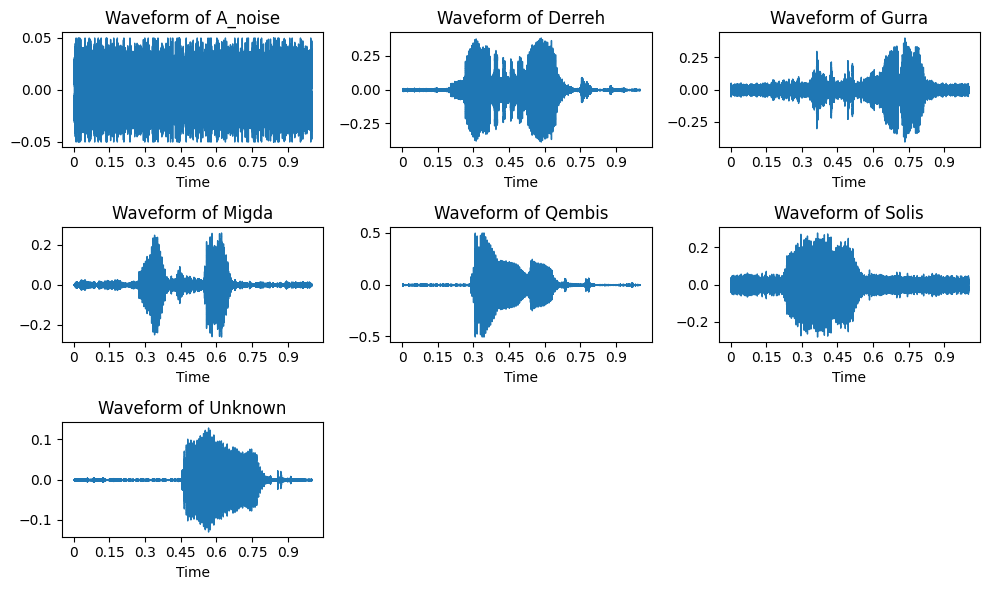

........Testing Data...........


In [7]:
print('........Training Data...........')
plot_waveforms(train_ds)
print('........Testing Data...........')
#plot_waveforms(test_ds)
#print('........Validation Data...........')
#plot_waveforms(val_ds)

# Extract MFCC from the Audio Dataset

### `extract_mfcc` Function

It is used to calculate Mel-frequency cepstral coefficients (MFCCs) for each audio signal within a given dictionary (audio_ds). This function iterates through the audio data, extracts MFCCs using Librosa, and stores them in a new dictionary (mfcc_ds). Here's a brief explanation of what's happening within the function:
1. It initializes an empty dictionary mfcc_ds to store MFCCs for each label.
2. It sets some constants like the duration of each audio clip, the target sampling rate, the number of MFCC coefficients, and the frame size/stride for feature extraction.
3. It iterates through each label in audio_ds and processes the audio signals for that label.
4. For each signal, it extracts MFCCs using Librosa's mfcc function, specifying parameters like the signal, sampling rate, number of MFCC coefficients, frame size, and frame stride.
5. The resulting MFCCs are stored in the mfcc_ds dictionary.

This function properly extract MFCC features from the audio signals. It organizes the MFCCs per label and stores them in a dictionary where each key represents a label, and the associated value is a list of MFCC matrices.

In [8]:
def extract_mfcc(audio_data):
    """
    Extract Mel-frequency cepstral coefficients (MFCCs) from audio signals.

    Args:
    - audio_data: Dictionary or np.ndarray.
        If dictionary: Dictionary containing audio signals for each label.
        If np.ndarray: Single audio signal as a 1D NumPy array.

    Returns:
    - mfcc_data: Dictionary or np.ndarray.
        If dictionary input: Dictionary containing MFCCs for each label.
        If single signal input: Extracted MFCC features.
    """

    # Constants
    duration = 1  # 1 second
    target_sr = 16000  # Sampling rate
    num_mfcc = 13  # Number of MFCCs
    # Calculate frame size in samples (25ms frame size)
    frame_size = int(0.025 * target_sr)  # 25ms frame size in samples
    frame_stride = frame_size // 2  # 50% overlap

    try:
        if isinstance(audio_data, dict):
            # Processing multiple audio signals (dictionary input)
            mfcc_data = {}
            for label, signals in audio_data.items():
                mfccs_per_label = []
                for signal in signals:
                    mfcc = librosa.feature.mfcc(y=signal, sr=target_sr, n_mfcc=num_mfcc, n_fft=frame_size, hop_length=frame_stride)
                    mfccs_per_label.append(mfcc.T)  # Transpose to have features in rows
                mfcc_data[label] = mfccs_per_label
        else:
            # Processing a single audio signal (NumPy array input)
            mfcc = librosa.feature.mfcc(y=audio_data, sr=target_sr, n_mfcc=num_mfcc, n_fft=frame_size, hop_length=frame_stride)
            mfcc_data = mfcc.T  # Transpose to have features in rows

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

    return mfcc_data

### Generating MFCCs Dataset

By using `extract_mfcc` function generate MFCCs dataset for Training, Testing, and Validation datasets, which could be used for machine learning-based tasks

In [9]:
# By using train_ds, test_ds, and val_ds dictionaries containing audio signals for different labels
# Here extract_mfcc function is used to extract MFCC feature

print('........Extracting MFCC for Training Data...........')
train_mfccs_ds = extract_mfcc(train_ds)

print('........Extracting MFCC for Testing Data...........')
test_mfccs_ds = extract_mfcc(test_ds)


print('........Extracting MFCC for Validation Data...........')
val_mfccs_ds = extract_mfcc(val_ds)


........Extracting MFCC for Training Data...........
........Extracting MFCC for Testing Data...........
........Extracting MFCC for Validation Data...........


### Plot the Waveform and MFCCs

The function, `plot_random_mfcc_with_waveform`, takes both mfcc_ds (dictionary of MFCCs) and audio_ds (dictionary of audio signals) as inputs. It randomly selects a set of MFCCs for each label from mfcc_ds and retrieves the corresponding audio signal from audio_ds. Then, it plots the MFCCs and the waveform side by side for visualization.

In [10]:
def plot_random_mfcc_with_waveform(mfcc_ds, audio_ds):
    for label, mfcc_list in mfcc_ds.items():
        random_index = random.randint(0, len(mfcc_list) - 1)  # Random index for MFCCs
        random_mfcc = mfcc_list[random_index]
        corresponding_audio = audio_ds[label][random_index]

        # Plotting MFCC
        plt.figure(figsize=(5, 3))
        plt.subplot(2, 1, 1)
        librosa.display.specshow(random_mfcc, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC for Class: {label}')

        # Plotting waveform
        plt.subplot(2, 1, 2)
        librosa.display.waveshow(corresponding_audio, sr=16000)
        plt.title(f'Waveform for Class: {label}')

        plt.tight_layout()
        plt.show()

........Plot waveform and MFCC for Training Data...........


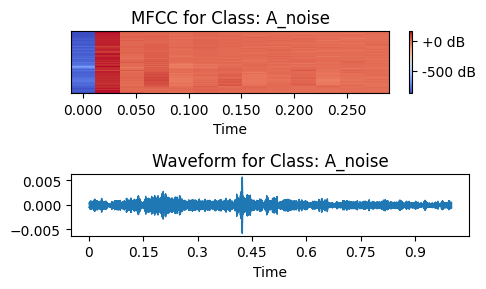

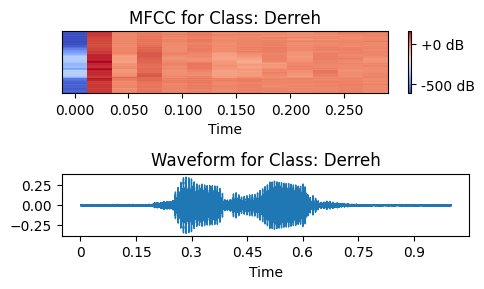

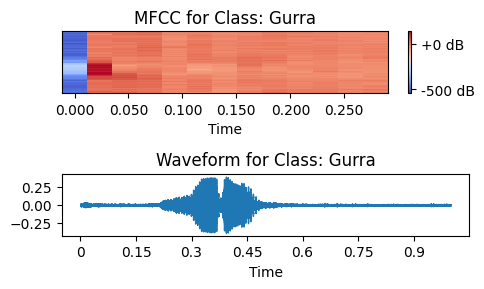

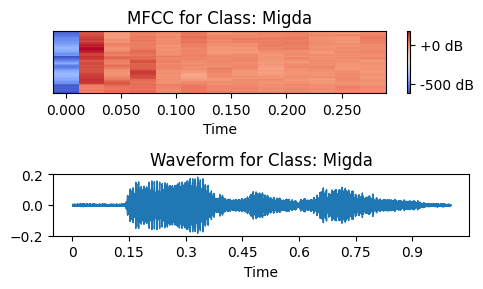

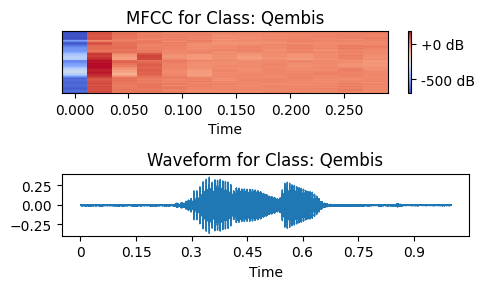

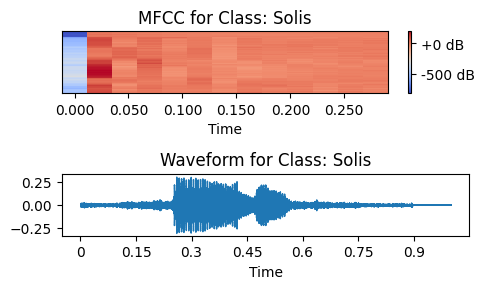

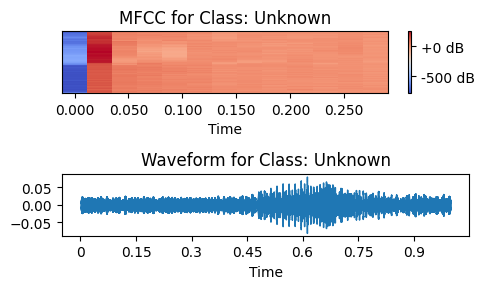

In [11]:
# Plotting random audio for each class in the training dataset
print('........Plot waveform and MFCC for Training Data...........')
plot_random_mfcc_with_waveform(train_mfccs_ds, train_ds)

# Plotting random audio for each class in the test dataset
#print('........Plot waveform and MFCC for Testing Data...........')

#plot_random_mfcc_with_waveform(test_mfccs_ds, test_ds)

# Plotting random audio for each class in the validation dataset
#print('........Plot waveform and MFCC for Validation Data...........')
#plot_random_mfcc_with_waveform(val_mfccs_ds, val_ds)

### Plot MFCCs of Audio

`plot_random_mfcc` function iterates through the MFCCs for each class in mfccs_ds and displays a random MFCC plot for each class in the subplot grid.

In [12]:
def plot_random_mfcc(mfccs_ds):
    fig, axs = plt.subplots(3, 3, figsize=(10, 8))
    # Flatten the axs array to iterate through it
    axs = axs.flatten()

    for i, (label, mfcc_list) in enumerate(mfccs_ds.items()):
        random_mfcc = random.choice(mfcc_list)
        print(f"Class: {label}, Random MFCC Shape: {random_mfcc.shape}")

        # Display the MFCC on the corresponding subplot
        librosa.display.specshow(random_mfcc, x_axis='time', ax=axs[i])
        axs[i].set_title(f'Random MFCC for Class: {label}')

    # Hide any empty subplots if there are fewer than 9 labels
    for j in range(len(mfccs_ds), 9):
        axs[j].axis('off')

    # Adjust colorbar, labels, and layout
    cax, _ = plt.cm.ScalarMappable().get_clim()
    #fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=axs, shrink=0.8)
    fig.text(0.5, 0.01, 'Time', ha='center')
    fig.text(0.01, 0.5, 'MFCC Coefficients', va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()


........Plot waveform and MFCC for Training Data...........
Class: A_noise, Random MFCC Shape: (81, 13)
Class: Derreh, Random MFCC Shape: (81, 13)
Class: Gurra, Random MFCC Shape: (81, 13)
Class: Migda, Random MFCC Shape: (81, 13)
Class: Qembis, Random MFCC Shape: (81, 13)
Class: Solis, Random MFCC Shape: (81, 13)
Class: Unknown, Random MFCC Shape: (81, 13)


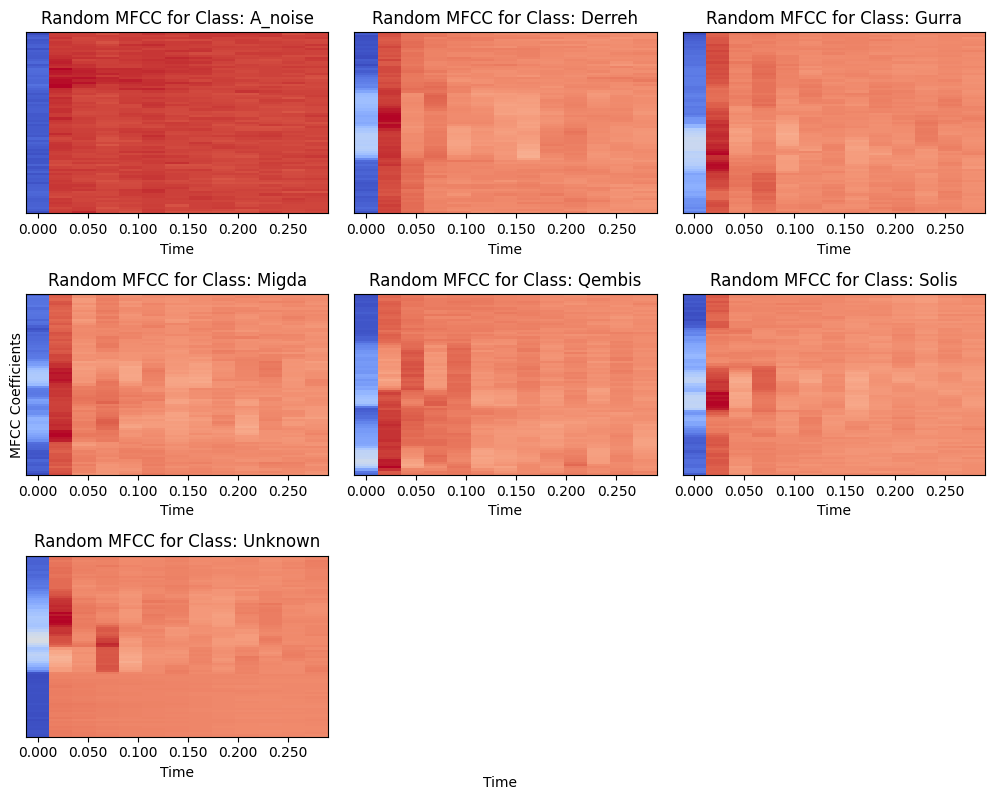

In [13]:
# Plotting random MFCC for each class in the validation dataset
print('........Plot waveform and MFCC for Training Data...........')
plot_random_mfcc(train_mfccs_ds)

In [14]:
# Plotting random MFCC for each class in the training dataset
print('........Plot waveform and MFCC for Testing Data...........')
#plot_random_mfcc(test_mfccs_ds)

# Plotting random MFCC for each class in the test dataset
print('........Plot waveform and MFCC for Validation Data...........')
#plot_random_mfcc(val_mfccs_ds)

........Plot waveform and MFCC for Testing Data...........
........Plot waveform and MFCC for Validation Data...........


### Print the Shape of MFCCs

Printing the shape of the MFCCs used for understanding the shape (dimensions) of the MFCC features extracted from audio signals for different classes. This information is crucial when preparing data for machine learning models or any further processing tasks.

The `print_random_mfccs_shapes` function iterates through each class in mfccs_ds, selects a random set of MFCCs from the list associated with that class, and prints the shape of the randomly selected MFCCs.

In [15]:
def print_random_mfccs_shapes(mfccs_ds):
    for label, mfccs_list in mfccs_ds.items():
        random_mfccs = random.choice(mfccs_list)
        print(f"Class: {label}, Random MFCCs Shape: {random_mfccs.shape}")

In [16]:

# Print random shapes of audio signals for each class in the training dataset
print("Random Shapes of MFCCs Signals in Training Dataset:")
print_random_mfccs_shapes(train_mfccs_ds)


#Print random shapes of audio signals for each class in the test dataset
#print("\nRandom Shapes of MFCCs Signals in Test Dataset:")
#print_random_mfccs_shapes(test_mfccs_ds)

# Print random shapes of audio signals for each class in the validation dataset
#print("\nRandom Shapes of MFCCs Signals in Validation Dataset:")
#print_random_mfccs_shapes(val_mfccs_ds)

Random Shapes of MFCCs Signals in Training Dataset:
Class: A_noise, Random MFCCs Shape: (81, 13)
Class: Derreh, Random MFCCs Shape: (81, 13)
Class: Gurra, Random MFCCs Shape: (81, 13)
Class: Migda, Random MFCCs Shape: (81, 13)
Class: Qembis, Random MFCCs Shape: (81, 13)
Class: Solis, Random MFCCs Shape: (81, 13)
Class: Unknown, Random MFCCs Shape: (81, 13)


## Prepare Data for Training:

### Preparing The Dataset For CNN model

The function `prepare_dataset` is used to process a dictionary of MFCCs (mfcc_ds) and prepare a dataset suitable for a Convolutional Neural Network (CNN) by combining the MFCCs, creating corresponding labels, converting them into NumPy arrays, reshaping for compatibility, and normalizing the MFCCs. Here's a breakdown of what the function does:
1. Combining MFCCs and Labels:
    - It iterates through each class in mfcc_ds and appends the MFCCs and their corresponding labels to separate lists (mfccs_p and labels_p).
    - The MFCCs are appended to mfccs_p, and labels are created using the index of each class in the keys of mfcc_ds.
2. Conversion to NumPy Arrays:
    - Converts the mfccs_p and labels_p lists to NumPy arrays.
3. Reshaping for CNN Compatibility:
    - Adds an extra dimension to the MFCCs (mfccs_p) to make them compatible with CNN input requirements.
4. Normalization:
    - Normalizes the MFCCs by dividing them by 255.0, likely to scale the data between 0 and 1, which is a common practice.

The resulting output consists of two NumPy arrays: mfccs_p containing the processed MFCCs and labels_p containing the corresponding labels. This function is tailored to process MFCCs for usage in a CNN-based model, ensuring that the data is formatted and scaled appropriately for training the neural network.

In [17]:
def prepare_dataset(mfcc_ds):
    """
    Prepare a dataset for CNN training using MFCCs and their corresponding labels.

    Args:
    - mfcc_ds (dict): Dictionary containing MFCCs for each class.

    Returns:
    - mfccs_p (numpy.ndarray): Processed MFCCs for CNN compatibility.
    - labels_p (numpy.ndarray): Corresponding labels for the MFCCs.
    """

    mfccs_p = []
    labels_p = []
    normalized = False  # Flag to track if normalization is already done

    try:
        for cls, mfcc_list in mfcc_ds.items():
            mfccs_p.extend(mfcc_list)
            labels_p.extend([list(mfcc_ds.keys()).index(cls)] * len(mfcc_list))

        # Convert to numpy arrays
        mfccs_p = np.array(mfccs_p)
        labels_p = np.array(labels_p)

        # Insert one axis
        mfccs_p = mfccs_p[..., np.newaxis]

        # Normalize the MFCCs
        mfccs_p = mfccs_p / 255.0

        # Check if data is already normalized
        '''if np.max(mfccs_p) > 1.0:
            normalized = True

        # If not normalized, proceed with normalization
        if not normalized:
            # Normalize the MFCCs
            mfccs_p = mfccs_p / 255.0'''

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None

    return mfccs_p, labels_p

In [18]:
# Prepare training dataset for CNN
train_mfccs, train_labels = prepare_dataset(train_mfccs_ds)
print(f'Train data shape: {train_mfccs.shape}')
print(f'Train label shape: {train_labels.shape}')
# Prepare test dataset for CNN
test_mfccs, test_labels=  prepare_dataset(test_mfccs_ds)
print(f'Test data shape: {test_mfccs.shape}')
print(f'Test label shape: {test_labels.shape}')

val_mfccs, val_labels = prepare_dataset(val_mfccs_ds)
print(f'Validation data shape: {val_mfccs.shape}')
print(f'Validation label shape: {val_labels.shape}')

Train data shape: (3152, 81, 13, 1)
Train label shape: (3152,)
Test data shape: (905, 81, 13, 1)
Test label shape: (905,)
Validation data shape: (480, 81, 13, 1)
Validation label shape: (480,)


### Setting up Some Essential Variables for Model Training


Based on the prepared MFCC dataset (train_mfccs) and corresponding class information.
1. Input Shape:
    -   It can define the input shape for the model by extracting the shape of the MFCCs from the training dataset (train_mfccs).
    - The shape is determined by slicing train_mfccs.shape from the second element onwards, excluding the number of samples.
2. Number of Classes:
    - Determining The number of classes by calculating the length of the dictionary (train_mfccs_ds) containing the training MFCCs for each class. The variable num_classes stores this count.
3. Class List:
    - class_list seems to contain the list of classes or labels for the training data. It's inferred from the variable class_train, which presumably holds the classes of the training dataset.

These steps are essential for configuring the neural network model's input shape (based on MFCCs) and determining the number of classes for classification tasks. They provide key information required for setting up the model architecture and training process.

In [19]:
# Define input shape (shape of MFCCs)
input_shape = train_mfccs.shape[1:]  # Excluding the number of samples
print(f'Input Shape: {input_shape}')

# Determine the number of classes
num_classes = len(train_mfccs_ds)
print(f'Num Classese: {num_classes}')

# Determine the list of Classes
class_list= class_train
print("Classes :", class_list)

Input Shape: (81, 13, 1)
Num Classese: 7
Classes : ['A_noise', 'Derreh', 'Gurra', 'Migda', 'Qembis', 'Solis', 'Unknown']


# Build CNN model

### `build_cnn_model` Function

It is constructing a Convolutional Neural Network (CNN) model using Keras Sequential API for a classification task based on the provided input shape and number of classes. Here's a breakdown of the model architecture:
1. Input Layer:
    - Conv2D layer with 32 filters, each of size (3, 3), using ReLU activation.
    - MaxPooling2D layer with a pool size of (2, 2) for downsampling.
2. Second Convolutional Layer:
    - Conv2D layer with 64 filters, each of size (3, 3), using ReLU activation.
    - MaxPooling2D layer with a pool size of (2, 2) for downsampling.
3. Flatten Layer:
    - Flattens the 2D output into a 1D vector.
4. Dense Layers:
    - Dense layer with 128 neurons using ReLU activation.
    - Dropout layer with a dropout rate of 0.5 for regularization to prevent overfitting.
    - Final Dense layer with a number of neurons equal to num_classes using softmax activation for classification output.
5. Model Compilation:
    - The model is compiled using the Adam optimizer.
    - Loss function is set to 'sparse_categorical_crossentropy' since classes are represented as integers.
    - Evaluation metric is set to 'accuracy' to monitor the model's performance.

This CNN architecture is a common design for image classification tasks and should work well for processing MFCCs organized in a 2D format. The model takes the input shape of the MFCCs and outputs predictions for the given number of classes.

In [20]:
def build_cnn_model(input_shape, num_classes):
    """
    Build a Convolutional Neural Network (CNN) model for classification.

    Args:
    - input_shape (tuple): Shape of the input data (excluding number of samples).
    - num_classes (int): Number of classes for classification.

    Returns:
    - model (tensorflow.keras.Model): Compiled CNN model.
    """

    try:
        # Define the CNN model
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),  # Add dropout for regularization
            layers.Dense(num_classes, activation='softmax')  # Output layer with number of classes
        ])

        # Compile the model
        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',  # Since classes are integers
                    metrics=['accuracy'])

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

    return model

Here using the `build_cnn_model` function to construct a Convolutional Neural Network (CNN) model based on the previously defined `input_shape` (shape of MFCCs) and `num_classes` (number of classes). The resulting model is assigned to the variable `model_cnn`.

In [21]:
# Build the CNN model
model_cnn = build_cnn_model(input_shape, num_classes)

### Train the model or `fit the model` 

By using the following parameters:
- EPOCH: Number of epochs for training.
- batch_size: Size of batches used for training.
- validation_data: Validation data to monitor the model's performance during training.
- callbacks: Includes the EarlyStopping callback to stop training if the validation loss doesn’t improve for a certain number of epochs (patience=3 in this case) and restores the best weights found during training (restore_best_weights=True).

This configuration allows for early stopping if the validation loss does not improve for a certain number of epochs, thereby preventing overfitting. The model will be trained using the training data (train_mfccs, train_labels) and validated using the validation data (val_mfccs, val_labels).

In [22]:
'''from sklearn.model_selection import train_test_split

EPOCH =100

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Assuming you have your data in train_mfccs and train_labels
# Splitting the data into train and validation sets
train_mfccs, val_mfccs, train_labels, val_labels = train_test_split(train_mfccs, train_labels, test_size=0.2, random_state=42)

# Training the model with EarlyStopping and using the splitted validation data
history_cnn = model_cnn.fit(train_mfccs, train_labels,
                            epochs=EPOCH,
                            batch_size=32,
                            validation_data=(val_mfccs, val_labels),
                            callbacks=[early_stopping])
'''

"from sklearn.model_selection import train_test_split\n\nEPOCH =100\n\n# Define the EarlyStopping callback\nearly_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)\n\n# Assuming you have your data in train_mfccs and train_labels\n# Splitting the data into train and validation sets\ntrain_mfccs, val_mfccs, train_labels, val_labels = train_test_split(train_mfccs, train_labels, test_size=0.2, random_state=42)\n\n# Training the model with EarlyStopping and using the splitted validation data\nhistory_cnn = model_cnn.fit(train_mfccs, train_labels,\n                            epochs=EPOCH,\n                            batch_size=32,\n                            validation_data=(val_mfccs, val_labels),\n                            callbacks=[early_stopping])\n"

Train validation is Splitted from the input data in folder

In [23]:
# Train the model
EPOCH =100

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history_cnn = model_cnn.fit(train_mfccs, train_labels,
                epochs=EPOCH,
                batch_size=32,
                validation_data=(val_mfccs, val_labels),
                callbacks=[early_stopping])

Epoch 1/100
99/99 [==============================] - 4s 28ms/step - loss: 1.3855 - accuracy: 0.4730 - val_loss: 0.8455 - val_accuracy: 0.7604
Epoch 2/100
99/99 [==============================] - 2s 20ms/step - loss: 0.7038 - accuracy: 0.7725 - val_loss: 0.5382 - val_accuracy: 0.8396
Epoch 3/100
99/99 [==============================] - 2s 19ms/step - loss: 0.5036 - accuracy: 0.8388 - val_loss: 0.4266 - val_accuracy: 0.8604
Epoch 4/100
99/99 [==============================] - 2s 21ms/step - loss: 0.3938 - accuracy: 0.8747 - val_loss: 0.3480 - val_accuracy: 0.8875
Epoch 5/100
99/99 [==============================] - 2s 19ms/step - loss: 0.3138 - accuracy: 0.9042 - val_loss: 0.2787 - val_accuracy: 0.9021
Epoch 6/100
99/99 [==============================] - 2s 17ms/step - loss: 0.2690 - accuracy: 0.9172 - val_loss: 0.2395 - val_accuracy: 0.9250
Epoch 7/100
99/99 [==============================] - 2s 19ms/step - loss: 0.2279 - accuracy: 0.9283 - val_loss: 0.2263 - val_accuracy: 0.9250
Epoch 

# Evaluate Model

### Plot Training and Validation Loss Curve

The `plot_training` function is create a visual representation of training and validation metrics (loss and accuracy) over epochs using Matplotlib. Here's a breakdown of what the function does:
1. Loss Plots:
    - Subplot 1 displays the training and validation loss over epochs.
    - It plots the training loss (metrics['loss']) against the epochs (history.epoch).
    - It also plots the validation loss (metrics['val_loss']) against the epochs.
    - The x-axis represents epochs, and the y-axis represents loss (measured in Cross Entropy).
2. Accuracy Plots:
    - Subplot 2 shows the training and validation accuracy over epochs.
    - It plots the training accuracy (metrics['accuracy']) against the epochs.
    - It also plots the validation accuracy (metrics['val_accuracy']) against the epochs.
    - The x-axis represents epochs, and the y-axis represents accuracy (%).
3. Visualization:
    - The function arranges the two subplots side by side for better comparison.
    - The title and labels for both subplots provide clarity on what each plot represents.

This function can be utilized to visualize the training and validation performance of a neural network model over epochs, showcasing how the loss and accuracy change during the training process.

In [24]:
def plot_training(history):
    metrics = history.history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, metrics['loss'], label='Training Loss')
    plt.plot(history.epoch, metrics['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), label='Training Accuracy')

    plt.plot(history.epoch, 100*np.array(metrics['val_accuracy']), label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()


Visualize the training and validation loss and Accuracy curves using the `plot_training` function by passing the history

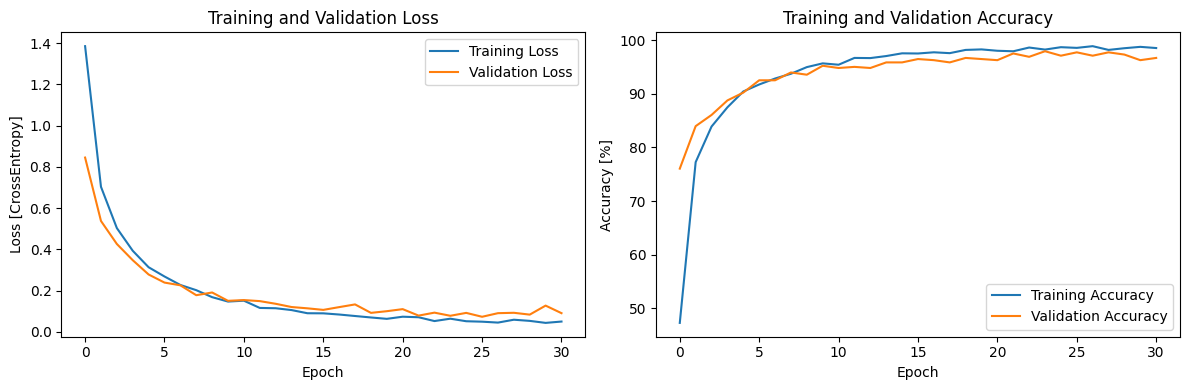

In [25]:
#Plot the training validation loss curve
plot_training(history_cnn)

### Evaluate Model Performance and Draw Confusion Matrix

`Evaluate_model` function is used to evaluate a trained model using test MFCCs and their corresponding labels. It performs several evaluation steps and displays the evaluation results, including accuracy, loss, and a confusion matrix visualized as a heatmap. Here's a breakdown of what the function does:
1. Model Evaluation:
    - Evaluates the model using the test_mfccs and test_leb (test labels) by calling model.evaluate.
    - Retrieves the accuracy and loss from the evaluation results.
2. Prediction and Confusion Matrix:
    - Obtains predictions from the model using model.predict on the test MFCCs (test_mfccs).
    - Converts the one-hot encoded predictions to class labels using np.argmax.
    - Computes the confusion matrix using sklearn.metrics.confusion_matrix.
3. Visualization:
    - Displays the confusion matrix as a heatmap using Matplotlib and Seaborn.

This function provides a comprehensive evaluation of the model's performance using test data, showcasing accuracy, loss, and a visual representation of the confusion matrix to understand the model's classification behavior.

In [26]:
def Evaluate_model(test_mfccs, test_leb, model, label_names):
    """
    Evaluate the trained model using test MFCCs and labels, and visualize its performance.

    Args:
    - test_mfccs (numpy.ndarray): Test MFCCs data.
    - test_leb (numpy.ndarray): Test labels corresponding to the test MFCCs.
    - model (tensorflow.keras.Model): Trained model to be evaluated.
    - label_names (list): List of label names for visualization.

    Returns:
    - None
    """

    try:
        print('.....Evaluating the model......')
        eval_results = model.evaluate(test_mfccs, test_leb)
        accuracy = eval_results[1]
        loss = eval_results[0]

        print(f'Accuracy in (%):- {accuracy * 100}')
        print(f'Loss:- {loss}')

        # Get predictions from the model
        predicted_labels = model.predict(test_mfccs)
        predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert one-hot encoded predictions to class labels

        # Compute confusion matrix
        cm = confusion_matrix(test_leb, predicted_labels)

        # Plot confusion matrix as a heatmap
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    except Exception as e:
        print(f"An error occurred during evaluation: {str(e)}")


Evaluate the trained model's performance and visualize the confusion matrix using the `Evaluate_model` function by passing the test MFCCs (test_mfccs), test labels (test_labels), the trained model (model_cnn), and a list of class names (class_list).

.....Evaluating the model......
29/29 [==============================] - 0s 6ms/step - loss: 0.0491 - accuracy: 0.9823
Accuracy in (%):- 98.23204278945923
Loss:- 0.04908660426735878
29/29 [==============================] - 1s 6ms/step


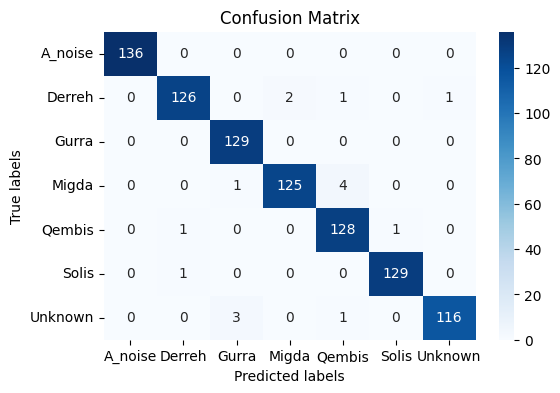

In [27]:
#Evaluate the model performance and see the confusion matrix
#label_list=['A_noise', 'Derreh', 'Gurra', 'Migda', 'Qembis', 'Solis', 'Unknown']

Evaluate_model(test_mfccs, test_labels, model_cnn, class_list)

In [28]:
'''.....Evaluating the model......
10/27 [==========>...................] - ETA: 0s - loss: 0.0591 - accuracy: 0.9812
27/27 [==============================] - 0s 7ms/step - loss: 0.0488 - accuracy: 0.9833
Accuracy in (%):- 98.33333492279053
Loss:- 0.04875065013766289
27/27 [==============================] - 0s 5ms/step'''

'.....Evaluating the model......\n10/27 [==========>...................] - ETA: 0s - loss: 0.0591 - accuracy: 0.9812\n27/27 [==============================] - 0s 7ms/step - loss: 0.0488 - accuracy: 0.9833\nAccuracy in (%):- 98.33333492279053\nLoss:- 0.04875065013766289\n27/27 [==============================] - 0s 5ms/step'

## Save Model

In [29]:
def model_save(model, model_filename):
    tf.saved_model.save(model, model_filename)
    #models.save_model(model, model_filename)

def model_save_tflite(keras_model, tflite_filename):
    converter = lite.TFLiteConverter.from_keras_model(keras_model)
    tflite_model = converter.convert()
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

In [30]:
# Save model in H5 keras model format
ks_model_filename = '../Model/modelS/Qf_mfccmodel_V003.h5'
model_save(model_cnn, ks_model_filename)

# Save the model in TensorFlow's 'saved_model' format
sv_model_filename = '../Model/modelS/Qf_mfccmodel_V003'
tf.saved_model.save(model_cnn, sv_model_filename)

# Convert the keras model to tflite model
tflite_filename1 = "../Model/modelS/Qf_mfccmodel_V003.tflite"
model_save_tflite(model_mfcc, tflite_filename1)

INFO:tensorflow:Assets written to: ../Model/modelS/Qf_mfccmodel_V003.h5\assets


INFO:tensorflow:Assets written to: ../Model/modelS/Qf_mfccmodel_V003.h5\assets


INFO:tensorflow:Assets written to: ../Model/modelS/Qf_mfccmodel_V003\assets


INFO:tensorflow:Assets written to: ../Model/modelS/Qf_mfccmodel_V003\assets


## Inference Testing 

The `predict_samples` function appears to be a prediction pipeline for audio samples using a given model. It does the following steps:
1. Loads an audio sample using librosa.load().
2. Adjusts the length of the signal to match the target sampling rate.
3. Extracts MFCC features from the signal using the extract_mfcc() function (not provided here).
4. Normalizes the MFCC features.
5. Reshapes and preprocesses the data for prediction with the given model.
6. Makes predictions using the provided model.
7. Calls a function `plot_bar()` to plot the predicted probabilities in bar graph.

In [31]:
def predict_samples(model, samples, classes, target_sr=16000):

    #Load Data
    signal, sr = librosa.load(samples, sr=target_sr, mono=True)
    #display(Audio(signal, rate=16000))
    #print ('signal shape:', signal.shape)
    if len(signal)< target_sr:
        signal=np.pad(signal, (0, target_sr - len(signal)), 'constant')
    elif len(signal>target_sr):
        signal = signal[:target_sr]
    #print(signal.shape)
    display(Audio(signal, rate=16000))

    # MFCC
    mfccd= extract_mfcc(signal)
    # Convert to numpy arrays
    mfccd = np.array(mfccd)
    # Normalization
    mfccd = mfccd/ 255.0

    #Add axis
    mfccd = mfccd[..., np.newaxis]
    mfccd = mfccd[np.newaxis, ...]
    #print('last mfcc shape', mfccd.shape)

    #Prediction using Model
    predict=model(mfccd)
    #print(predict)

    plot_bar(predict, classes)

    return predict

In [32]:
def plot_bar(predictions, classes):
    # Extracting probabilities
    probabilities = predictions.numpy()[0]

    # Generating x-axis indices based on the number of probabilities
    indices = range(len(probabilities))

    predicted_class = tf.argmax(predictions, axis=1)
    idx= predicted_class.numpy()[0]

    # Creating the bar plot for the probabilities
    plt.figure(figsize=(5, 3))
    plt.bar(indices, probabilities, color='skyblue')

    # Adding labels and title
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.title(f'Predicted Classes: {classes[idx]}')

    # Set xticks labels with class names
    plt.xticks(indices, classes, rotation=45)

    # Showing the plot
    plt.tight_layout()
    plt.show()

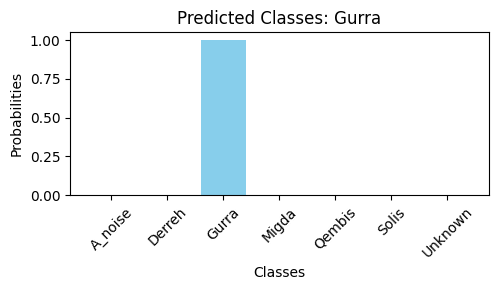

In [33]:
samp= '../_V_Data/Qf_For_test/Afar-afe_test4.wav'
labell= ['A_noise', 'Derreh', 'Gurra', 'Migda', 'Qembis', 'Solis', 'Unknown']
predds= predict_samples(model_cnn, samp, labell)



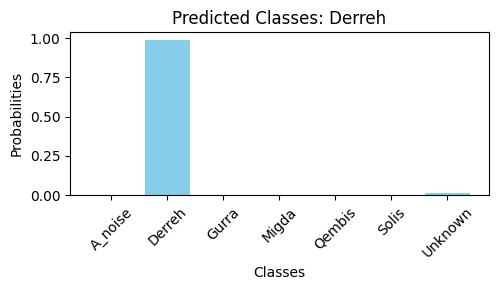

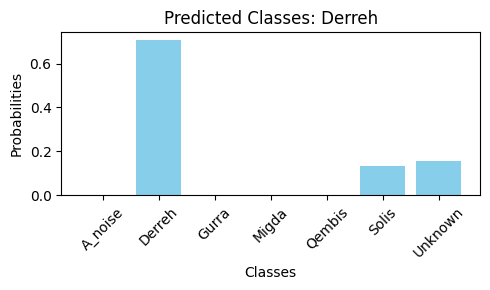

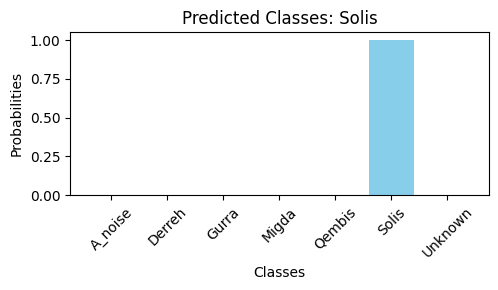

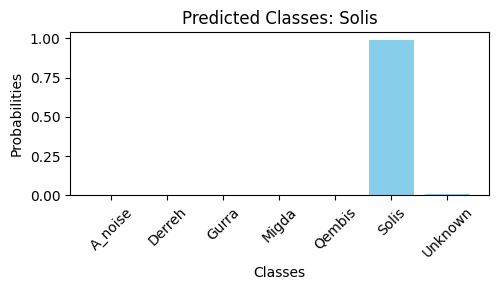

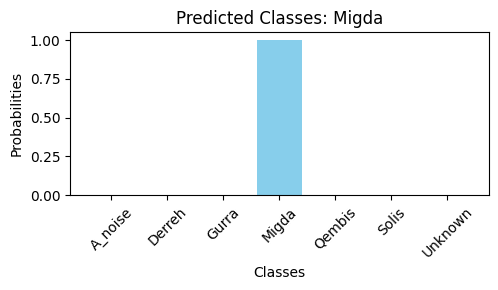

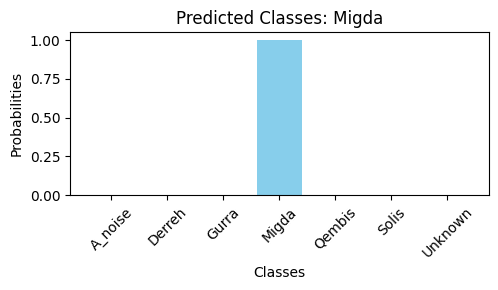

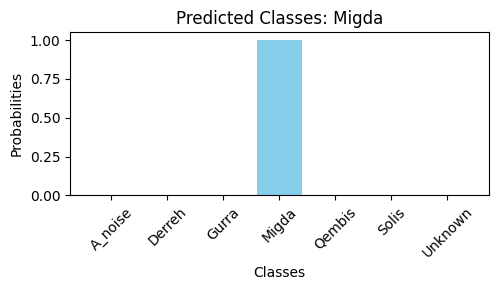

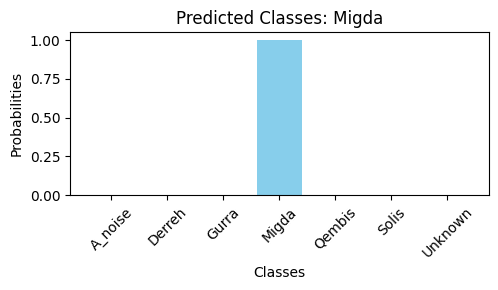

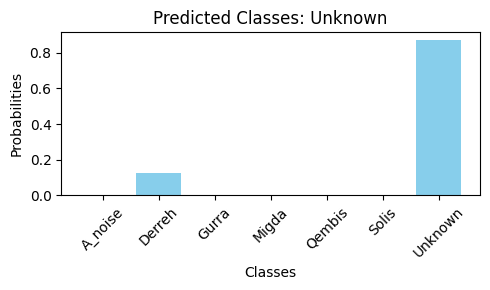

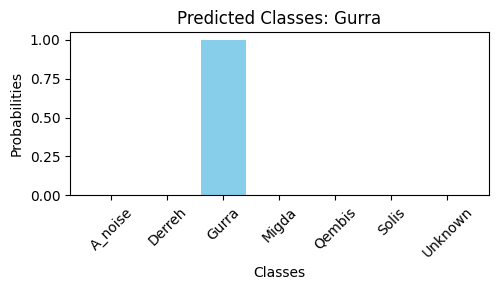

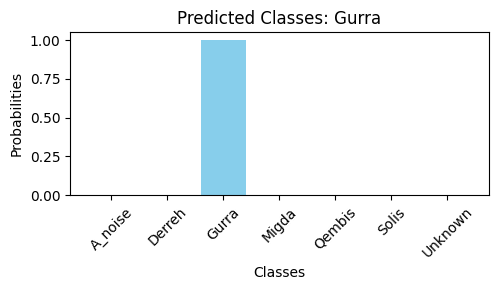

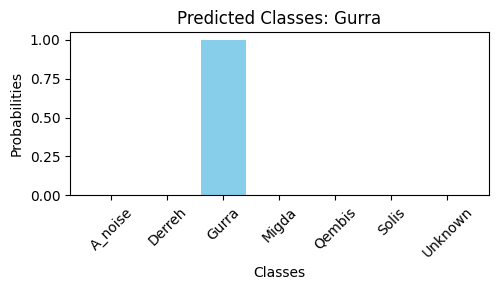

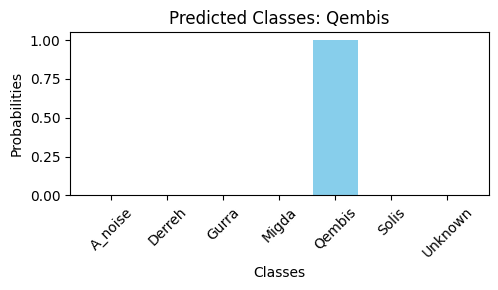

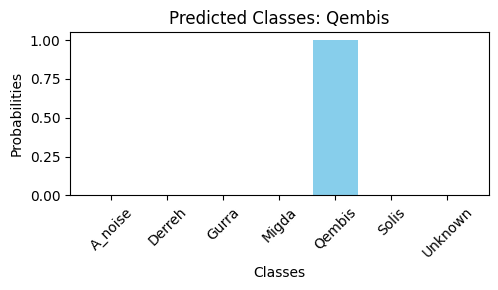

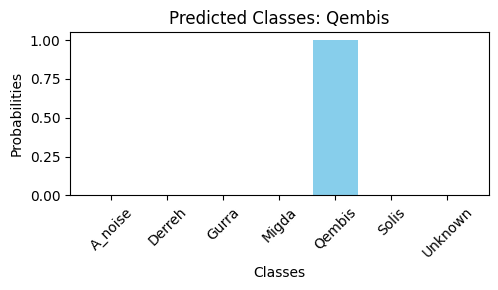

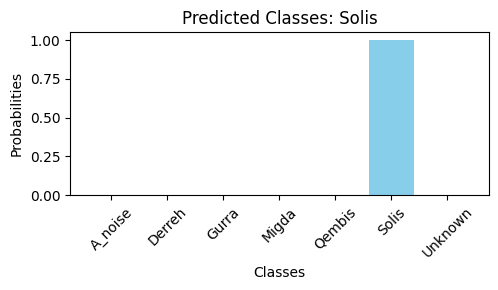

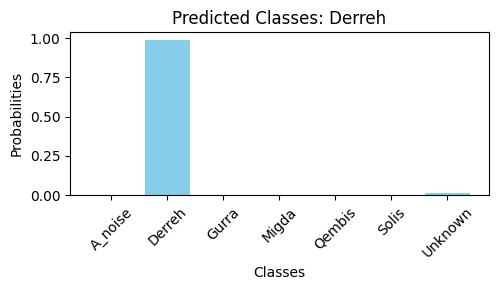

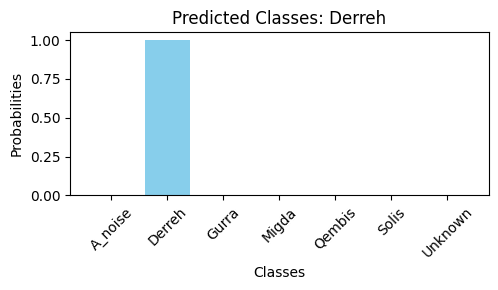

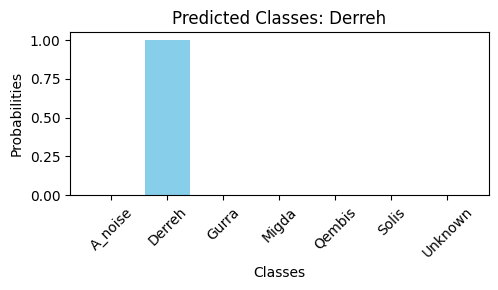

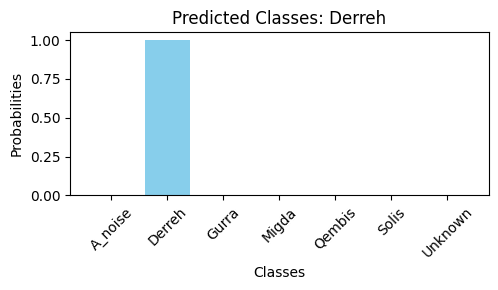

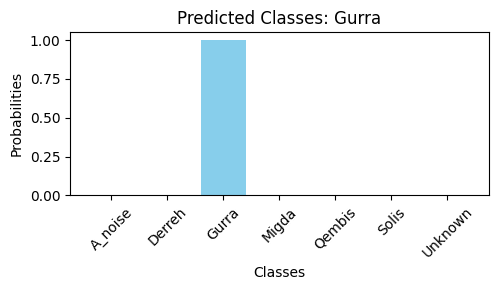

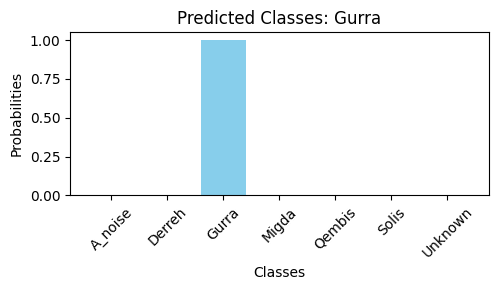

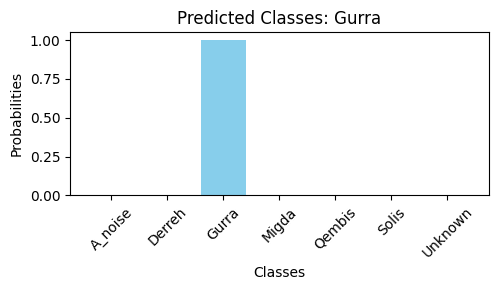

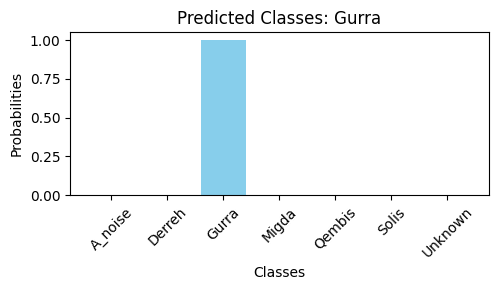

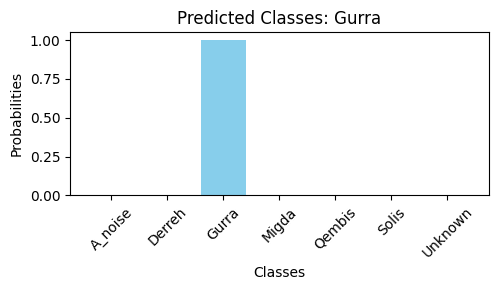

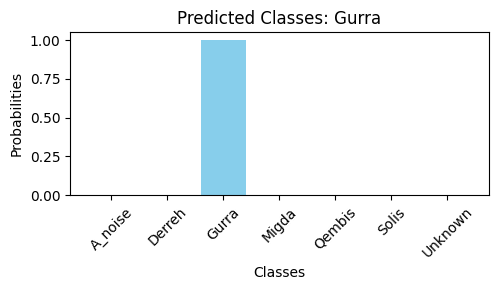

In [34]:
# Directory containing folders for each class
test_a= "../_V_Data/Qf_For_test"#/splitted_QF/Train_MM"
test_d = os.listdir(test_a)
for audio in test_d:
    sampl = os.path.join(test_a, audio)
    predict_samples(model_cnn, sampl, labell)




# END